# LZGraphs: Advanced Features

This notebook showcases advanced features available in LZGraphs v2.0.0:

1. **`from_airr`** — Load data from AIRR-formatted DataFrames
2. **`batch_walk_probability`** — Compute sequence probabilities in bulk
3. **`compare_repertoires`** — One-call repertoire comparison
4. **`graph_union`** — Merge two graphs
5. **Saturation analysis** — `diversity_profile` and `saturation_curve`
6. **Custom exceptions** — Structured error handling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)

from LZGraphs import (
    AAPLZGraph, NDPLZGraph,
    graph_union, compare_repertoires,
    NodeEdgeSaturationProbe,
    EmptyDataError, MissingColumnError, InvalidSequenceError,
    NoGeneDataError, MissingNodeError
)

/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load example data
data_aa = pd.read_csv('ExampleData3.csv', index_col=0)
data_nt = pd.read_csv('ExampleData2.csv', index_col=0)
print(f"Amino acid data: {data_aa.shape[0]} sequences")
print(f"Nucleotide data: {data_nt.shape[0]} sequences")

Amino acid data: 5000 sequences
Nucleotide data: 5000 sequences


## 1. Loading AIRR-Formatted Data with `from_airr`

The [AIRR standard](https://docs.airr-community.org/) uses column names like `junction_aa`, `junction`, `v_call`, and `j_call`. LZGraphs expects `cdr3_amino_acid`, `cdr3_rearrangement`, `V`, and `J`.

The `from_airr` classmethod handles the column mapping automatically:

In [3]:
# Simulate AIRR-formatted data by renaming columns
airr_data = data_aa.rename(columns={
    'cdr3_amino_acid': 'junction_aa',
    'V': 'v_call',
    'J': 'j_call'
})
print("AIRR columns:", airr_data.columns.tolist())
print(airr_data.head(3))

AIRR columns: ['junction_aa', 'v_call', 'j_call']
             junction_aa       v_call      j_call
12787  CASSGLAGSRSYNEQFF   TRBV2-1*01  TRBJ2-1*01
11502     CASSPTGGVYEQYF  TRBV19-1*01  TRBJ2-7*01
18830    CASSQTGESNQPQHF   TRBV6-5*01  TRBJ1-5*01


In [4]:
# Build graph directly from AIRR data
graph_airr = AAPLZGraph.from_airr(airr_data)
print(f"Nodes: {len(graph_airr.nodes)}, Edges: {len(graph_airr.edges)}")
print(f"Has gene data: {graph_airr.genetic}")

Nodes: 1692, Edges: 9528
Has gene data: True


In [5]:
# You can also provide a custom column mapping
custom_data = data_aa.rename(columns={
    'cdr3_amino_acid': 'my_cdr3_col',
    'V': 'my_v_col',
    'J': 'my_j_col'
})

graph_custom = AAPLZGraph.from_airr(
    custom_data,
    column_map={
        'my_cdr3_col': 'cdr3_amino_acid',
        'my_v_col': 'V',
        'my_j_col': 'J'
    }
)
print(f"Custom mapping — Nodes: {len(graph_custom.nodes)}, Edges: {len(graph_custom.edges)}")

Custom mapping — Nodes: 1692, Edges: 9528


## 2. Batch Walk Probability with `batch_walk_probability`

Instead of looping over sequences to compute probabilities one-by-one, `batch_walk_probability` processes them all at once and returns a NumPy array.

In [6]:
# Build a graph
graph = AAPLZGraph(data_aa, verbose=False)

# Compute probabilities for all sequences in one call
sequences = data_aa['cdr3_amino_acid'].tolist()
probs = graph.batch_walk_probability(sequences[:200])

print(f"Result type: {type(probs).__name__}, shape: {probs.shape}")
print(f"Mean probability: {probs.mean():.2e}")
print(f"Non-zero: {np.count_nonzero(probs)} / {len(probs)}")

Result type: ndarray, shape: (200,)
Mean probability: 7.20e-08
Non-zero: 200 / 200


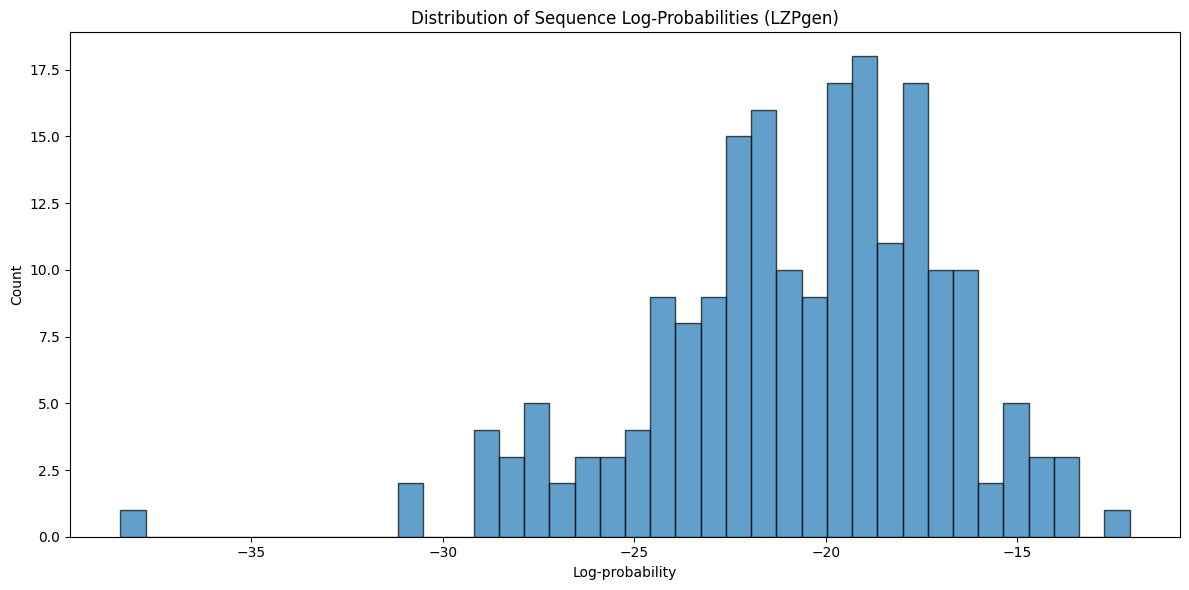

In [7]:
# Use log-probabilities to avoid numerical underflow on long sequences
log_probs = graph.batch_walk_probability(sequences[:200], use_log=True)

plt.hist(log_probs[log_probs > -np.inf], bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('Log-probability')
plt.ylabel('Count')
plt.title('Distribution of Sequence Log-Probabilities (LZPgen)')
plt.tight_layout()
plt.show()

## 3. Repertoire Comparison with `compare_repertoires`

The `compare_repertoires` function computes a comprehensive suite of comparison metrics between two LZGraphs in a single call.

In [8]:
# Build two graphs from different halves of the data
graph_1 = AAPLZGraph(data_aa.iloc[:2500], verbose=False)
graph_2 = AAPLZGraph(data_aa.iloc[2500:], verbose=False)

# Compare them
comparison = compare_repertoires(graph_1, graph_2)
print(comparison.to_string())

js_divergence           0.027725
cross_entropy_1_2       8.117911
cross_entropy_2_1       8.194729
kl_divergence_1_2            inf
kl_divergence_2_1            inf
node_entropy_1          7.437893
node_entropy_2          7.426534
edge_entropy_1          2.557820
edge_entropy_2          2.542099
shared_nodes          946.000000
shared_edges         2967.000000
jaccard_nodes           0.559102
jaccard_edges           0.311398


In [9]:
# Key metrics explained
print(f"Jensen-Shannon Divergence: {comparison['js_divergence']:.4f}")
print(f"  (0 = identical, 1 = completely different)")
print()
print(f"Jaccard Node Similarity:   {comparison['jaccard_nodes']:.4f}")
print(f"Jaccard Edge Similarity:   {comparison['jaccard_edges']:.4f}")
print(f"  (1 = identical sets, 0 = no overlap)")
print()
print(f"Shared nodes: {comparison['shared_nodes']:.0f}")
print(f"Shared edges: {comparison['shared_edges']:.0f}")

Jensen-Shannon Divergence: 0.0277
  (0 = identical, 1 = completely different)

Jaccard Node Similarity:   0.5591
Jaccard Edge Similarity:   0.3114
  (1 = identical sets, 0 = no overlap)

Shared nodes: 946
Shared edges: 2967


## 4. Graph Union with `graph_union`

Merge two graphs into one. The result is equivalent to building a graph from the combined sequence sets.

In [10]:
print(f"Graph 1: {len(graph_1.nodes)} nodes, {len(graph_1.edges)} edges")
print(f"Graph 2: {len(graph_2.nodes)} nodes, {len(graph_2.edges)} edges")

# Merge graph_2 into graph_1
merged = graph_union(graph_1, graph_2)
print(f"\nMerged:  {len(merged.nodes)} nodes, {len(merged.edges)} edges")

# Compare with building from scratch
graph_full = AAPLZGraph(data_aa, verbose=False)
print(f"Full:    {len(graph_full.nodes)} nodes, {len(graph_full.edges)} edges")

Graph 1: 1327 nodes, 6293 edges
Graph 2: 1311 nodes, 6202 edges


100%|██████████| 1692/1692 [00:36<00:00, 46.20it/s]



Merged:  1692 nodes, 9528 edges


Full:    1692 nodes, 9528 edges


## 5. Saturation Analysis

Saturation curves show how quickly new patterns are discovered as more sequences are processed. This measures the "diversity" or "complexity" of a repertoire.

### Saturation Curve

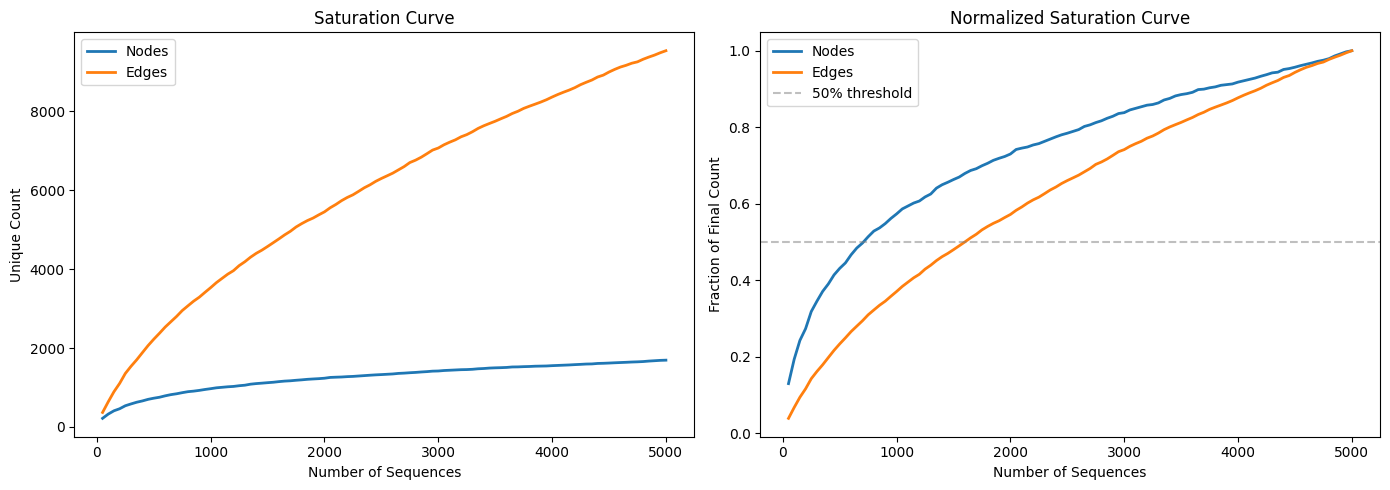

In [11]:
probe = NodeEdgeSaturationProbe(node_function='aap')

# Compute saturation curve
curve = probe.saturation_curve(sequences, log_every=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(curve['n_sequences'], curve['nodes'], label='Nodes', linewidth=2)
ax1.plot(curve['n_sequences'], curve['edges'], label='Edges', linewidth=2)
ax1.set_xlabel('Number of Sequences')
ax1.set_ylabel('Unique Count')
ax1.set_title('Saturation Curve')
ax1.legend()

# Normalized view
ax2.plot(curve['n_sequences'], curve['nodes'] / curve['nodes'].iloc[-1], 
         label='Nodes', linewidth=2)
ax2.plot(curve['n_sequences'], curve['edges'] / curve['edges'].iloc[-1], 
         label='Edges', linewidth=2)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax2.set_xlabel('Number of Sequences')
ax2.set_ylabel('Fraction of Final Count')
ax2.set_title('Normalized Saturation Curve')
ax2.legend()

plt.tight_layout()
plt.show()

### Diversity Profile

The `diversity_profile` method combines multiple saturation metrics into a single summary:

In [12]:
probe2 = NodeEdgeSaturationProbe(node_function='aap')
profile = probe2.diversity_profile(sequences)
print(profile.T.to_string())

                       0
n_sequences  5000.000000
final_nodes  1692.000000
final_edges  9528.000000
k50_nodes     800.000000
k50_edges    1600.000000
ausc_nodes      0.733777
ausc_edges      0.620904


In [13]:
print("Metric explanations:")
print(f"  K50 (nodes):  {profile['k50_nodes'].iloc[0]} sequences needed to find 50% of all node patterns")
print(f"  K50 (edges):  {profile['k50_edges'].iloc[0]} sequences needed to find 50% of all edge patterns")
print(f"  AUSC (nodes): {profile['ausc_nodes'].iloc[0]:.3f} — higher = more gradual discovery (more diverse)")
print(f"  AUSC (edges): {profile['ausc_edges'].iloc[0]:.3f} — higher = more gradual discovery (more diverse)")

Metric explanations:
  K50 (nodes):  800 sequences needed to find 50% of all node patterns
  K50 (edges):  1600 sequences needed to find 50% of all edge patterns
  AUSC (nodes): 0.734 — higher = more gradual discovery (more diverse)
  AUSC (edges): 0.621 — higher = more gradual discovery (more diverse)


## 6. Custom Exceptions

LZGraphs provides a hierarchy of exceptions for clear, actionable error messages. This makes it easy to handle errors gracefully in your analysis pipelines.

In [14]:
# EmptyDataError — raised when you pass empty data
try:
    empty_df = pd.DataFrame(columns=['cdr3_amino_acid'])
    AAPLZGraph(empty_df, verbose=False)
except EmptyDataError as e:
    print(f"EmptyDataError: {e}")

print()

# MissingColumnError — raised when required columns are missing
try:
    bad_df = pd.DataFrame({'wrong_column': ['CASSAF']})
    AAPLZGraph(bad_df, verbose=False)
except MissingColumnError as e:
    print(f"MissingColumnError: {e}")

print()

# NoGeneDataError — raised when gene operations are called on a non-genetic graph
try:
    # Build graph without gene columns
    no_gene_data = data_aa[['cdr3_amino_acid']]
    graph_no_genes = AAPLZGraph(no_gene_data, verbose=False)
    graph_no_genes.genomic_random_walk()  # requires gene data
except NoGeneDataError as e:
    print(f"NoGeneDataError: {e}")

EmptyDataError: DataFrame is empty. Cannot build LZGraph from zero sequences.

MissingColumnError: Required column 'cdr3_amino_acid' not found in DataFrame. Available columns: ['wrong_column']



NoGeneDataError: Genomic data function requires gene annotation data, but `self.genetic` is False.

In [15]:
from LZGraphs import LZGraphError

# All LZGraphs exceptions inherit from LZGraphError,
# so you can catch all LZGraphs errors with a single handler:
try:
    AAPLZGraph(pd.DataFrame(), verbose=False)
except LZGraphError as e:
    print(f"Caught {type(e).__name__}: {e}")

Caught MissingColumnError: Required column 'cdr3_amino_acid' not found in DataFrame


## Summary

| Feature | Function/Method | Description |
|---------|----------------|-------------|
| AIRR loading | `AAPLZGraph.from_airr(data)` | Auto-maps AIRR column names |
| Batch probability | `graph.batch_walk_probability(seqs)` | Vectorized LZPgen computation |
| Repertoire comparison | `compare_repertoires(g1, g2)` | Full comparison metric suite |
| Graph merging | `graph_union(g1, g2)` | Combine two graphs |
| Saturation curves | `NodeEdgeSaturationProbe` | Pattern discovery analysis |
| Error handling | `EmptyDataError`, `MissingColumnError`, etc. | Structured exception hierarchy |